In [1]:
import sys
sys.path.append('../src/')

import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
import pandas as pd
import data_io
import utils
import matplotlib.pyplot as plt

#### 1. Read in dataset

In [2]:
print(str(data_io.input_cleaned))
EXCEL_OPTIONS = {'strings_to_urls': False,
                 'strings_to_formulas': False}

/Users/elisabethsilver/Documents/cancer_crowdfunding/cancer-crowdfunding-explorer/data


In [3]:
import os
if os.path.exists(data_io.input_cleaned/'gfm'/'cancer_w_locs_and_text_features_census.xlsx'):
    merge_ndi = False
    print('path exists')
    df = pd.read_excel(data_io.input_cleaned/'gfm'/'cancer_w_locs_and_text_features_census.xlsx', 
                       encoding = 'utf-8')
else:
    print('still need to merge GFM and Census data')
    df = pd.read_excel(data_io.input_cleaned/'gfm'/'cancer_w_locs_and_text_features.xlsx', 
                       encoding = 'utf-8')

path exists


#### Format variables for analysis

In [4]:
if 'winsorized_goal' not in df.columns.values:
    #citation to support winsorizing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5548942/#!po=41.6667
    df['winsorized_goal'] = winsorize(df['goal_amnt'], limits = .05)
    df.loc[pd.isnull(df['goal_amnt']), 'winsorized_goal'] = np.nan
    print(df['winsorized_goal'].mean())
    print(df['goal_amnt'].mean())
    df['changed_goal'] = df['winsorized_goal'] != df['goal_amnt']
    df.loc[pd.isnull(df['winsorized_goal']), 'changed_goal'] = False
    print('Number of campaigns that were changed in winsorization: ', df.changed_goal.value_counts())
    df['orig_percent_goal'] = df['raised_amnt']/df['goal_amnt']
else:
    print('winsorization already done')


winsorization already done


In [5]:
if 'percent_goal' not in df.columns.values:
    df['percent_goal'] = df['raised_amnt']/df['winsorized_goal']
    print('Number of campaigns with goal amount > 100%: ', len(df[df['percent_goal']>1.]))
    df.loc[df['orig_percent_goal']>1., 'orig_percent_goal'] = 1.
    df.loc[df['percent_goal']>1., 'percent_goal'] = 1.
    df['orig_met_goal'] = df['orig_percent_goal'] >=1.
    df['met_goal'] = df['percent_goal'] >=1.
    print('Number of campaigns meeting goal pre-transform: ', df['orig_met_goal'].value_counts())
    print('Number of campaigns meeting goal post-transform: ',df['met_goal'].value_counts())
else:
    print('percent goal already calculated')

percent goal already calculated


In [6]:

df['log_raised_amnt'] = np.log(df['raised_amnt'])
df.loc[np.isinf(df['log_raised_amnt']), 'log_raised_amnt'] = np.nan

df['avg_contribution'] = df['raised_amnt']/df['num_contributors']
df.loc[np.isinf(df['avg_contribution']), 'avg_contribution'] = np.nan

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
#Convert location info to strings
df['state_fips'] = df['state_x'].map(utils.state_fips)
df['county_fips'] = df['county_fips_int'].apply(utils.format_county_fip)

df['state_county_fips_str'] = df['state_fips'] + df['county_fips']
df['state_county_fips_str'].isnull().sum()

0

#### 2. After running get_census_data.ipynb and clustr.R, calculate the Neighborhood Deprivation Index and merge with the GFM dataset

In [8]:
#after running the PCA in R on the census variables, load the dataset back in to compute the deprivation index
def get_ndi_quartiles():
    pca = pd.read_csv(data_io.input_cleaned/'census'/'census_w_factor_weights.csv')
    census = pd.read_csv(data_io.input_cleaned/'census'/'acs_five_year_est.csv')
    census['state_county_fips_str'] = census['state_county_fips_str'].apply(utils.format_state_county_fip)
    pca['state_county_fips_str'] = pca['state_county_fips'].apply(utils.format_state_county_fip)

    colnames = pca.columns.to_list()
    cols_to_sum = [i for i in colnames if 'weighted' in i]

    #pca = pca[temp_cols]
    print(colnames)
    pca['sum'] = 0
    for c in cols_to_sum:
        pca['sum'] += pca[c]

    cols_to_sum.append('state_county_fips_str')
    cols_to_sum.append('sum')
    pca = pca[cols_to_sum]
    from sklearn import preprocessing
    pca['standardized_ndi'] = preprocessing.scale(pca['sum'])
    pca = pd.merge(pca, census, how='left', on='state_county_fips_str')
    
    QUANTS = (np.quantile(pca['standardized_ndi'].values, [.25, .5, .75]))

    def _get_quantile(x):
        if x <= QUANTS[0]:
            return 1
        if x > QUANTS[0] and x <= QUANTS[1]:
            return 2
        if x > QUANTS[1] and x <= QUANTS[2]:
            return 3
        if x > QUANTS[2]:
            return 4
    cols_to_drop = [c for c in pca.columns.to_list() if 'weighted' in c]
    print(cols_to_drop)
    pca['ndi_quantile'] = pca['standardized_ndi'].apply(_get_quantile)
    
    pca.drop(columns = cols_to_drop, inplace=True)
    return pca

### Generate Census stats by NDI quartiles

In [9]:
#Descriptives for PCA/census vars
if merge_ndi:
    ndi_df = get_ndi_quartiles()
    ndi_map = {1: 'NDI Quartile 1 (least deprived)',
                2: 'NDI Quartile 2',
                3: 'NDI Quartile 3',
                4: 'NDI Quartile 4 (most deprived)'
              }

    census_vars = pd.read_csv(data_io.input_cleaned/'census'/'census_variables.csv')
    census_var_dict = dict(zip(census_vars['variable_label'].to_list(), census_vars['pretty_label'].to_list()))

    census_var_dict['percent_single_parent'] = '% With Single-Parent Households'
    census_var_dict['percent_less_35k'] = '% of Households with Annual Income < $35k'
    ndi_df['NDI Quartile'] = ndi_df['ndi_quantile'].map(ndi_map)

    vars_to_plot = ['unemployment_rate', 'percent_poverty', 'no_health_insurance', 
                    'ed_percent_highschool', 'has_internet', 'percent_single_parent', 
                    'percent_less_35k']
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize = (10,12))
    ax_array = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]


    for i in range(0, len(vars_to_plot)):
        if i == 1:
            ndi_df.pivot(columns="NDI Quartile", values=vars_to_plot[i]).plot.hist(bins=100, ax = ax_array[i])
            ax_array[i].legend(loc = 'center left', bbox_to_anchor = (1, .5))
        else:
            ndi_df.pivot(columns="NDI Quartile", values=vars_to_plot[i]).plot.hist(bins=100, ax = ax_array[i],
                                                                                      legend = False)
        xlab = census_var_dict[vars_to_plot[i]]
        if '%' not in xlab:
            xlab += ' (%)'
        ax_array[i].set_xlabel(xlab)
        ptitle = f'{xlab}'
        ax_array[i].set_title(ptitle)
        
    plt.suptitle('Socioeconomic Status Variables by NDI Quartile', y = 1.01, x = 0.4)
    fig.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.savefig(data_io.output_plots/'ndi_comparisons.png', dpi = 400, bbox_inches = 'tight')
    plt.show()
else:
    print('skipping NDI summary')

skipping NDI summary


### Merge Census Stats with GFM dataset

In [10]:
#check if NDI quartiles are in the dataset
test = [i for i in df.columns.values if 'ndi_quantile' in i]
merged_complete = True if len(test) > 0 else False
print(merged_complete)
#if NDI quartiles aren't already in GFM dataset, add them here:
if merged_complete == False:

    #Get the NDI quartiles--Note: Must run clustr.R to obtain them!
    quarts = get_ndi_quartiles()
    print(len(df))

    #Merge with GFM dataset
    df = pd.merge(df, quarts, how='left', on='state_county_fips_str')
    print(len(df))
    df.rename(columns={'county_x':'county_name', 'county_y':'county_fips_int'}, inplace=True)
    print(df['county_fips_int'].isnull().sum())

True


#### If the combined dataset hasn't been saved yet, set save to True

In [11]:

if merge_ndi:
    writer = pd.ExcelWriter(data_io.input_cleaned/'gfm'/'cancer_w_locs_and_text_features_census.xlsx',
                           engine='xlsxwriter', options = EXCEL_OPTIONS)
    df.to_excel(writer, encoding='utf-8', index= False)
    writer.close()
else:
    print('df already saved')

df already saved


In [12]:
ndi_map = {1: '1 (least deprived)', 
           2: '2',
           3: '3',
           4: '4 (most deprived)'
          }

#convert NDI quartiles to factors (instead of integers)
df['ndi_quantile_f'] = df['ndi_quantile'].map(ndi_map)
vals = df['ndi_quantile_f'].value_counts()
for v in vals.index:
    print(v)
    print(vals[v])
    print(vals[v]/len(df))
    


1 (least deprived)
53323
0.3697593786838638
2
42806
0.2968310103321545
3
35644
0.247167325428195
4 (most deprived)
12437
0.0862422855557867


### Univariate Analysis

In [13]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#### Define functions for univariate analysis

In [14]:

def format_percent(x, digits = 2):
    if type(x) != str and pd.isnull(x)==False:
        if digits == 2:
            x = '{:.2%}'.format(x)
        else:
            x = '{:.3%}'.format(x)
    return x

def format_decimal(x, digits = 2):
    if type(x) != str and type(x) != bool and pd.isnull(x)==False:
        if digits == 2:
            x = '{0:,.2f}'.format(x)
        else:
            x = '{0:,.3f}'.format(x)
        return x
    else:
        return x
    
def format_mean_sd(mean, sd):
    mean = format_decimal(mean)
    sd = format_decimal(sd)
    
    return f"${mean} (${sd})"
    


#Run an anova
def compare_info_by_group(df, comp_cols, group_col):
    for c in range(0, len(comp_cols)):
        temp = df[~pd.isnull(df[comp_cols[c]])]
        new = temp.groupby(group_col[c])
        temp = temp[~pd.isnull(temp[group_col[c]])]
        
        mc = MultiComparison(temp[comp_cols[c]], temp[group_col[c]])
        
        result = mc.tukeyhsd()
        mc_result = result.summary()
        results_as_html = mc_result.as_html()
        result_df = pd.read_html(results_as_html, header=0)[0]
        result_df
        return result_df
    
    
    

In [15]:
#Set columns for comparisons with labels for plotting
mention_cols = ['brave', 'nice', 'thank', 'self_reliance', 'battle', 'tx_type', 'oop_type', 'insurance_type',
               'ctype']

groups = [m+'_is_mentioned' for m in mention_cols]

#for labeling multivariate outputs
pretty_groups = ['Bravery ', 'Warmth ','Gratitude ', 'Self-reliance ', 'Militaristic Metaphors ',
                'Treatment ', 'OOP Cost ', 'Insurance ', 'Cancer Type ']
#for labeling univariate outputs
pretty_groups_univ = [i.rstrip() for i in pretty_groups]
print(len(groups))
print(len(pretty_groups))
group_label_dict_univ = dict(zip(groups, pretty_groups_univ))
group_label_dict = {}

9
9


#### Run Chi-sq tests to compare mention of indicators by NDI quartile

In [16]:
from scipy.stats import chi2_contingency
#Run pairwise comparisons for Chi-2 test
def get_chi_2_post_hoc(df, groups):
    all_results = pd.DataFrame()
    for g in groups:
        ct = pd.crosstab(df[g], df['ndi_quantile_f'])
        ct.reset_index(inplace= True)
        ct['var'] = g
        ct.sort_values(by = g, inplace=True, ascending = False)
        ct['var_value'] = ['True', 'False']
        ct.drop(columns = [g], inplace=True)
        comp_1_2 = ct[['1 (least deprived)', '2']]
        comp_1_3 = ct[['1 (least deprived)', '3']]
        comp_1_4 = ct[['1 (least deprived)', '4 (most deprived)']]
        comp_2_3 = ct[['2', '3']]
        comp_2_4 = ct[['2', '4 (most deprived)']]
        comp_3_4 = ct[['3', '4 (most deprived)']]
        
        comp_arr = [comp_1_2, comp_1_3, comp_1_4, comp_2_3, comp_2_4, comp_3_4]
        comp_strs = ['comp_1_2', 'comp_1_3', 'comp_1_4', 'comp_2_3', 'comp_2_4', 'comp_3_4']
        for i in range(0, len(comp_arr)):
            chi2, p, dof, ex = (chi2_contingency(comp_arr[i]))
            #Bonferoni correction: 
            min_p = 0.05/len(comp_strs)
            if p < min_p:
                ct.loc[0, f'{comp_strs[i]}_sig_diff'] = True
            else:
                ct.loc[0, f'{comp_strs[i]}_sig_diff'] = False
            ct.loc[0, f'chi_2_{comp_strs[i]}'] = chi2
            ct.loc[0, f'dof_{comp_strs[i]}'] = dof
            ct.loc[0, f'p_val_{comp_strs[i]}'] = p
            
        all_results = all_results.append(ct, ignore_index = True)
        
    return all_results
    
    


In [17]:

#Run omnibus chi_2 tests for NDI
def calculate_chi_2_ndi(df, g, group_label_dict):
    ndi_quants = ['1 (least deprived)', '2', '3', '4 (most deprived)']
    ct = pd.crosstab(df[g], df['ndi_quantile_f'])
    temp_idx = ct.index.astype(str).to_list()        
    chi2, p, dof, ex = (chi2_contingency(ct))
    ct.set_index(ct.index.astype(str)+f'_{g}', inplace=True)
    
    ct.loc[f'expected_{temp_idx[0]}_{g}', :] = ex[0, :]
    
    ct.loc[f'expected_{temp_idx[1]}_{g}', :] = ex[1, :]
    
    ct.loc[f'expected_less_obs_{g}', :] = ct.loc[f'expected_False_{g}', :] - ct.loc[f'False_{g}', :]
    for nq in ndi_quants:
        ct.loc[f'percent_mentioned_{g}', nq] = format_percent(ct.loc[f'True_{g}', nq] / (ct.loc[f'True_{g}', nq] + 
                                                                          ct.loc[f'False_{g}', nq]))
        
        ct.loc[f'expected_percent_mentioned_{g}', nq] = format_percent(ct.loc[f'expected_True_{g}', nq] / 
                                                                 (ct.loc[f'True_{g}', nq] + ct.loc[f'False_{g}', nq]))
    idx_list = ct.index.to_list()
    pretty_labels = []
    for i in idx_list:
        if 'expected' in i and 'less' not in i:
            if 'expected_percent' in i:
                pretty_labels.append('Expected Percent Mentioned')
            elif 'False' in i:
                pretty_labels.append('Expected False')
            else:
                pretty_labels.append('Expected True')
        else:
            if 'False' in i:
                pretty_labels.append('Observed False')
            elif 'True' in i:
                pretty_labels.append('Observed True')
            elif 'less' in i:
                pretty_labels.append('Expected True - Observed True')
            else:
                pretty_labels.append(' ')

    ct['var'] = group_label_dict[g]
    ct['chi_2'] = chi2
    ct['p'] = p
    ct['df'] = dof
    ct['pretty_labels'] = pretty_labels
    
    return ct
        
        
ndi_quants = ['1 (least deprived)', '2', '3', '4 (most deprived)']
temp_groups = groups.copy()
#first, get the omnibus chi-square tests
all_comps = pd.DataFrame()
for g in temp_groups:
    print(g)
    #get the omnibus
    temp_ct = calculate_chi_2_ndi(df, g, group_label_dict_univ)
    all_comps = all_comps.append(temp_ct)
    
all_comps.reset_index(inplace=True)
#next, get the post-hoc comparisons
post_hoc = get_chi_2_post_hoc(df, groups)


brave_is_mentioned
nice_is_mentioned
thank_is_mentioned
self_reliance_is_mentioned
battle_is_mentioned
tx_type_is_mentioned
oop_type_is_mentioned
insurance_type_is_mentioned
ctype_is_mentioned


In [18]:
all_comps

ndi_quantile_f,index,1 (least deprived),2,3,4 (most deprived),var,chi_2,p,df,pretty_labels
0,False_brave_is_mentioned,37219,30593,25727,9237,Bravery,126.180352,3.598508e-27,3,Observed False
1,True_brave_is_mentioned,16104,12213,9917,3200,Bravery,126.180352,3.598508e-27,3,Observed True
2,expected_False_brave_is_mentioned,38002.4,30507.1,25402.9,8863.64,Bravery,126.180352,3.598508e-27,3,Expected False
3,expected_True_brave_is_mentioned,15320.6,12298.9,10241.1,3573.36,Bravery,126.180352,3.598508e-27,3,Expected True
4,expected_less_obs_brave_is_mentioned,783.39,-85.8961,-324.131,-373.363,Bravery,126.180352,3.598508e-27,3,Expected True - Observed True
...,...,...,...,...,...,...,...,...,...,...
58,expected_False_ctype_is_mentioned,8920.45,7161.05,5962.91,2080.6,Cancer Type,53.659458,1.326290e-11,3,Expected False
59,expected_True_ctype_is_mentioned,44402.6,35645,29681.1,10356.4,Cancer Type,53.659458,1.326290e-11,3,Expected True
60,expected_less_obs_ctype_is_mentioned,327.445,103.048,-207.088,-223.405,Cancer Type,53.659458,1.326290e-11,3,Expected True - Observed True
61,percent_mentioned_ctype_is_mentioned,83.89%,83.51%,82.69%,81.47%,Cancer Type,53.659458,1.326290e-11,3,


In [19]:
def unpack_percent(x):
    if type(x) == str:
        x = x[0:-1]
    return float(x)


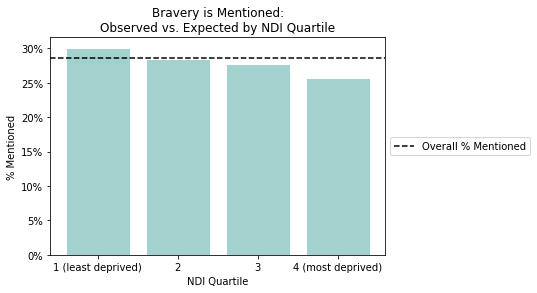

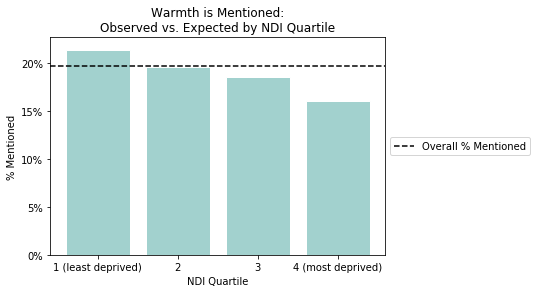

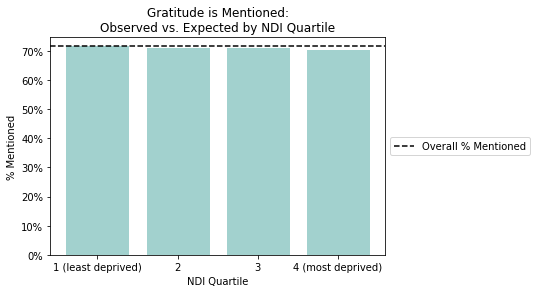

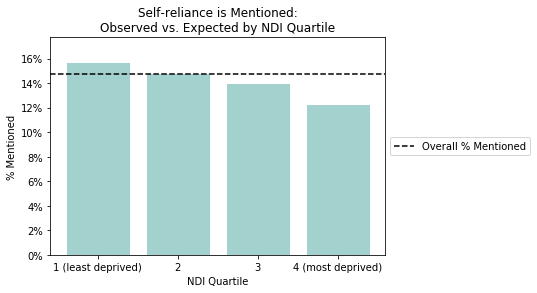

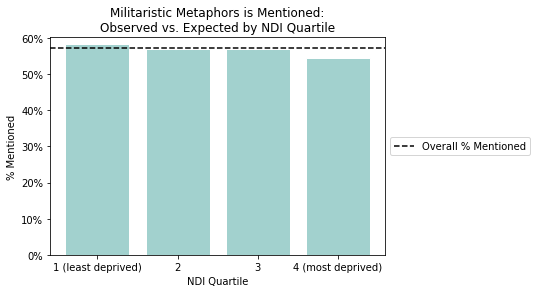

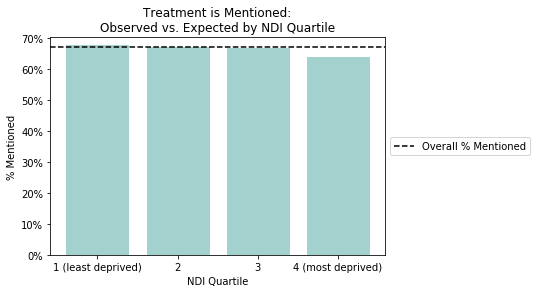

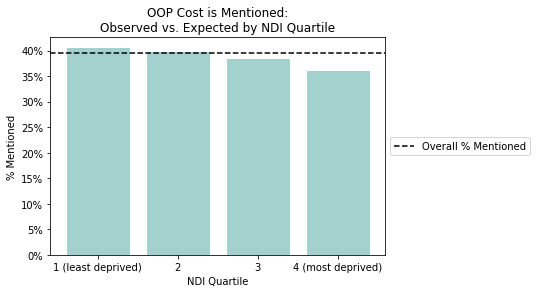

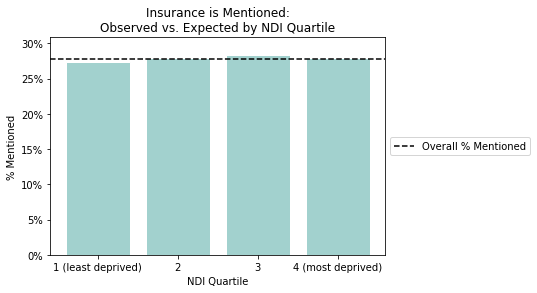

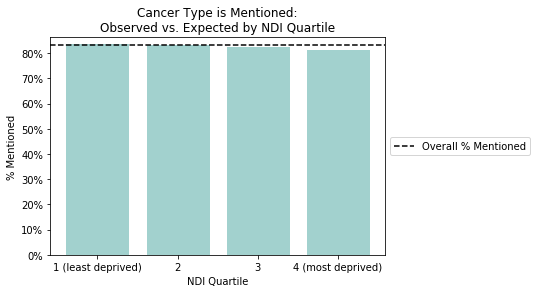

In [85]:
#This function helps visualize X2 test results
def plot_chi_2(chi_2, group):
    ndi_quants = ['1 (least deprived)', '2', '3', '4 (most deprived)']
    
    temp_chi = chi_2[chi_2['index'].str.contains(group)]
    temp_chi = temp_chi[temp_chi['index'].str.contains('percent')]
    temp_chi = temp_chi.set_index('index')
    temp_list = []
    for nq in ndi_quants:
        temp_list.append(unpack_percent(temp_chi.loc[f'percent_mentioned_{group}', nq]))
    bars = temp_list
    hline = unpack_percent(temp_chi.loc[f'expected_percent_mentioned_{group}', ndi_quants[0]])
    title = temp_chi.loc[f'expected_percent_mentioned_{group}', 'var'] + ' is Mentioned:\nObserved vs. Expected by NDI Quartile'
    fig, ax = plt.subplots()
    ax.bar(ndi_quants, bars, fc = '#A2D1CE', edgecolor = 'w')
    ax.axhline(hline, linestyle = 'dashed', label = 'Overall % Mentioned', c = 'k')
    ax.set_title(title)
    ax.set_ylim(bottom = 0, top = hline + 3)
    ax.set_ylabel('% Mentioned')
    ax.set_xlabel('NDI Quartile')
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
    plt.legend(loc = 'center left',  bbox_to_anchor = (1, .5))
    plt.show()

for g in temp_groups:
    
    plot_chi_2(all_comps, g)    


In [20]:
#save the results if you want to
save = False
if save:
    all_comps.to_csv(data_io.output_analysis/'chi2_tests_mention_by_NDI.csv')
    post_hoc.to_csv(data_io.output_analysis/'chi2_post_hoc_v1.csv')

In [21]:
df.ndi_quantile_f.value_counts()

1 (least deprived)    53323
2                     42806
3                     35644
4 (most deprived)     12437
Name: ndi_quantile_f, dtype: int64

#### Run ANOVAs on NDI quartiles

In [22]:
comparisons = ['raised_amnt', 'winsorized_goal', 'shares', 'num_contributors',
              'percent_goal', 'avg_contribution']
group_vals = np.unique(df['ndi_quantile_f'].values)
#Iterate over all comparisons
for c in comparisons:
    mod = ols(f'{c} ~ ndi_quantile_f',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    aov_table.reset_index(inplace=True)
    print(aov_table)
    multicomp = compare_info_by_group(df, [c], ['ndi_quantile_f'])
    
    for i in range(0, len(aov_table)):
        for col in aov_table.columns:
            multicomp.loc[i, col] = aov_table.loc[i, col]
            
    multicomp.rename(columns={'index':'omnibus'}, inplace=True)
    multicomp['outcome'] = c
    
    if c == comparisons[0]:
        all_multicomp = multicomp.copy()
    else:
        all_multicomp = pd.concat((all_multicomp, multicomp), ignore_index=True)

            index        sum_sq        df           F         PR(>F)
0  ndi_quantile_f  1.025332e+11       3.0  255.016945  4.520059e-165
1        Residual  1.926089e+13  143715.0         NaN            NaN
            index        sum_sq        df          F        PR(>F)
0  ndi_quantile_f  8.455060e+10       3.0  58.768746  5.845943e-38
1        Residual  6.732013e+13  140377.0        NaN           NaN
            index        sum_sq        df          F        PR(>F)
0  ndi_quantile_f  3.479112e+07       3.0  15.586115  3.927450e-10
1        Residual  1.007780e+11  135443.0        NaN           NaN
            index        sum_sq        df         F        PR(>F)
0  ndi_quantile_f  5.027429e+06       3.0  99.63183  2.028072e-64
1        Residual  2.302998e+09  136920.0       NaN           NaN
            index        sum_sq        df           F         PR(>F)
0  ndi_quantile_f     90.393848       3.0  292.558424  2.417560e-189
1        Residual  14407.189328  139886.0         NaN  

In [23]:
#save results of ANOVA w post-hoc tests
if save:
    all_multicomp.to_csv(data_io.output_analysis/'anovas_by_NDI_quartile.csv', index=False)

#### Run comparisons in amount raised by potentially important confounding variables (year created, number of contributors, number of social media shares)

In [24]:
#Compare outcomes by year
group_vals = np.unique(df['year'].values)

for c in comparisons:
    mod = ols(f'{c} ~ year',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    aov_table.reset_index(inplace=True)
    print(aov_table)
    multicomp = compare_info_by_group(df, [c], ['year'])
    
    for i in range(0, len(aov_table)):
        for col in aov_table.columns:
            multicomp.loc[i, col] = aov_table.loc[i, col]
            
    multicomp.rename(columns={'index':'omnibus'}, inplace=True)
    multicomp['outcome'] = c
    
    if c == comparisons[0]:
        mc_year = multicomp.copy()
    else:
        mc_year = pd.concat((mc_year, multicomp), ignore_index=True)

      index        sum_sq        df           F        PR(>F)
0      year  2.577763e+10       1.0  191.578803  1.533597e-43
1  Residual  1.933765e+13  143717.0         NaN           NaN
      index        sum_sq        df          F        PR(>F)
0      year  3.735421e+10       1.0  77.838127  1.130844e-18
1  Residual  6.736733e+13  140379.0        NaN           NaN
      index        sum_sq        df           F         PR(>F)
0      year  7.175173e+08       1.0  970.915827  2.137101e-212
1  Residual  1.000953e+11  135445.0         NaN            NaN
      index        sum_sq        df           F        PR(>F)
0      year  2.280867e+06       1.0  135.444714  2.730331e-31
1  Residual  2.305744e+09  136922.0         NaN           NaN
      index        sum_sq        df           F         PR(>F)
0      year     84.008336       1.0  815.325708  8.226760e-179
1  Residual  14413.574840  139888.0         NaN            NaN
      index        sum_sq        df          F        PR(>F)
0     

In [25]:
raised_amount_year_info = df.groupby(['year']).agg({'raised_amnt': ['count', 'mean', 'std']})
#raised_amount_year_info.to_csv(data_io.output_analysis/'raised_amnt_by_year_desc.csv')


    
raised_amount_year_info.columns = ['count', 'mean', 'std']
raised_amount_year_info['mean_sd_fmt'] = raised_amount_year_info.apply(lambda x: format_mean_sd(x['mean'],
                                                                                               x['std']),
                                                                      axis = 1)
raised_amount_year_info


,count,mean,std,mean_sd_fmt
year,,,,
2010,13,4927.000000,4032.684218,"$4,927.00 ($4,032.68)"
2011,115,6667.695652,7327.058766,"$6,667.70 ($7,327.06)"
2012,683,6016.825769,9537.629907,"$6,016.83 ($9,537.63)"
2013,2879,6326.572074,13683.290492,"$6,326.57 ($13,683.29)"
2014,10378,5973.354404,10612.816814,"$5,973.35 ($10,612.82)"
2015,19929,6515.170806,9659.698559,"$6,515.17 ($9,659.70)"
2016,18077,8264.801958,12102.547239,"$8,264.80 ($12,102.55)"
2017,30015,6720.293553,13304.776238,"$6,720.29 ($13,304.78)"
2018,38870,6001.769848,11994.719782,"$6,001.77 ($11,994.72)"


In [26]:
if save:
    raised_amount_year_info.to_csv(data_io.output_analysis/'raised_amnt_by_year_desc.csv')


In [27]:
#save results of ANOVA w post-hoc tests
if save:
    mc_year.to_csv(data_io.output_analysis/'anovas_by_campaign_year.csv', index=False)

In [28]:
from scipy.stats import spearmanr

Get spearman rank correlations between amount raised and potential confounders

In [29]:
corr_vars = ['num_contributors', 'shares', 'winsorized_goal']

temp_df = df[['num_contributors', 'shares', 'winsorized_goal', 'raised_amnt']]
corrs = temp_df.corr(method = 'spearman')
corrs = corrs[['raised_amnt']]

temp_df = df.dropna(subset=['raised_amnt'])

for i in range(0, len(corr_vars)):
    temp = temp_df.dropna(subset=[corr_vars[i]])
    r, p = spearmanr(temp[corr_vars[i]], temp['raised_amnt'])
    print(r, p)
    corrs.loc[corr_vars[i], 'p_value'] = p
if save:   
    corrs.to_csv(data_io.output_analysis/'raised_amnt_confound_corrs.csv')
corrs


0.8887348244008915 0.0
0.5406951774282014 0.0
0.48346111863972263 0.0


,raised_amnt,p_value
num_contributors,0.888735,0.0
shares,0.540695,0.0
winsorized_goal,0.483461,0.0
raised_amnt,1.000000,NaN


#### Next, run t-tests on binary variables

In [82]:
from sklearn.utils import resample
#From: https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/validating-and-inspecting-time-series-models?ex=12
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles


In [83]:
def compare_two_groups(df, group_condition, group_col, group_labels,
                       comparison_cols = ['raised_amnt', 'winsorized_goal',
                                          'num_contributors', 'shares',
                                         'percent_goal', 'avg_contribution']):
    
    result_df= pd.DataFrame()
    g1 = df[df[group_col] == group_condition]
    g2 = df[df[group_col]!= group_condition]
    #Get t-test results for all comparison variables
    for i in range(0, len(comparison_cols)):
        #generate overall stats
        result_df.loc[i, 'percent_mentioned'] = format_percent(len(g1)/len(df))
        result_df.loc[i, 'overall_mean'] = df[comparison_cols[i]].mean()
        result_df.loc[i, 'overall_std_err'] = df[comparison_cols[i]].sem()
        result_df.loc[i, 'overall_sd'] = df[comparison_cols[i]].std()
        result_df.loc[i, 'comparison_var'] = comparison_cols[i]
        #Initialize temporary DF to store this comparison's results
        comp_result_df = pd.DataFrame()
        new_vnames = ['_g1', '_g2']
        #Set up a list of DFs to iterate over
        dfs = [g1, g2]
        k = 0
        for k in range(0, len(dfs)):
            temp_df = dfs[k].copy()
            comp_result_df.loc[0, 
                               f'n_missing{new_vnames[k]}'] = temp_df[comparison_cols[i]].isnull().sum()
            temp_df.dropna(subset = [comparison_cols[i]], inplace = True)
            comp_result_df.loc[0, f'n{new_vnames[k]}'] = len(temp_df)
            comp_result_df.loc[0, f'mean{new_vnames[k]}'] = temp_df[comparison_cols[i]].mean()
            comp_result_df.loc[0, f'fmtd_mean{new_vnames[k]}'] = format_decimal(temp_df[comparison_cols[i]].mean())
            comp_result_df.loc[0, f'std_err{new_vnames[k]}'] = temp_df[comparison_cols[i]].sem()
            comp_result_df.loc[0, f'sd{new_vnames[k]}'] = format_decimal(temp_df[comparison_cols[i]].std())
            comp_result_df.loc[0, f'name{new_vnames[k]}'] = group_labels[k]
            boot = bootstrap(temp_df[comparison_cols[i]].values)
            c_intervals = bootstrap_interval(temp_df[comparison_cols[i]])
            comp_result_df.loc[0, f'low_mean_ci{new_vnames[k]}'] = c_intervals[0, 0]
            comp_result_df.loc[0, f'up_mean_ci{new_vnames[k]}'] = c_intervals[1, 0]
            comp_result_df.loc[0, f'fmtd_mean_std{new_vnames[k]}'] = format_mean_sd(comp_result_df.loc[0, f'mean{new_vnames[k]}'],
                                                                                   comp_result_df.loc[0, f'sd{new_vnames[k]}'])
            #Replace old DF with temp DF to avoid null values when running t-test
            dfs[k] = temp_df
        
        #Run the t-test
        cm = sms.CompareMeans(sms.DescrStatsW(dfs[0][comparison_cols[i]]), 
                              sms.DescrStatsW(dfs[1][comparison_cols[i]]))
        #Format result as pandas DF
        comp_res = cm.summary()
        comp_res = comp_res.as_html()
        comp_res = pd.read_html(comp_res, header=0)[0]
        #Add this comparison's results to the overall result dataframe
        result_df.loc[i, 't_stat'] = comp_res.loc[0, 't']
        result_df.loc[i, 'p_val'] = comp_res.loc[0, 'P>|t|']
        result_df.loc[i, 'mean_diff'] = comp_res.loc[0, 'coef']
        result_df.loc[i, 'lower_ci'] = comp_res.loc[0, '[0.025']
        result_df.loc[i, 'upper_ci'] = comp_res.loc[0, '0.975]']
        temp_colnames = comp_result_df.columns.to_list()
        for t in temp_colnames:
            result_df.loc[i, t] = comp_result_df.loc[0, t]
    
    return result_df

def extract_varname(x):
    if type(x) == str:
        if ' is ' in x:
            split_loc = x.find(' is ')
            new_x = x[0:split_loc]
        else:
            new_x = x
        new_x = new_x.replace(" ", "\n")
        if '-' in new_x:
            new_x = "Self-\nReliance"
        return new_x

In [84]:
group_label_dict = {}
for i in range(0, len(groups)):
    group_label_dict[groups[i]] = [pretty_groups[i] + 'is mentioned', pretty_groups[i] + 'is not mentioned']

In [85]:
#Remove NDI from groups temporarily since they can't be subjected to a t-test    
temp_groups = ['self_reliance_is_mentioned', 'brave_is_mentioned', 'battle_is_mentioned', 'tx_type_is_mentioned',
               'oop_type_is_mentioned', 'insurance_type_is_mentioned', 'ctype_is_mentioned', 'nice_is_mentioned',
              'thank_is_mentioned']

In [86]:


i = 0
for i in range(0, len(temp_groups)):
    print(group_label_dict[temp_groups[i]])
    temp = compare_two_groups(df, True, temp_groups[i], 
                                   group_label_dict[temp_groups[i]])
    temp['var_name'] = temp_groups[i]
    temp_fmtd_name = group_label_dict[temp_groups[i]][0]
    temp['fmtd_var_name'] = extract_varname(temp_fmtd_name)
    if i == 0:
        t_tests = temp.copy()
    else:
        t_tests = pd.concat([t_tests, temp], ignore_index= True)





['Self-reliance is mentioned', 'Self-reliance is not mentioned']
['Bravery is mentioned', 'Bravery is not mentioned']
['Militaristic Metaphors is mentioned', 'Militaristic Metaphors is not mentioned']
['Treatment is mentioned', 'Treatment is not mentioned']
['OOP Cost is mentioned', 'OOP Cost is not mentioned']
['Insurance is mentioned', 'Insurance is not mentioned']
['Cancer Type is mentioned', 'Cancer Type is not mentioned']
['Warmth is mentioned', 'Warmth is not mentioned']
['Gratitude is mentioned', 'Gratitude is not mentioned']


In [80]:
t_tests

,percent_mentioned,overall_mean,overall_std_err,overall_sd,comparison_var,t_stat,p_val,mean_diff,lower_ci,upper_ci,...,std_err_g2,sd_g2,name_g2,low_mean_ci_g2,up_mean_ci_g2,low_mean_ci_2_g2,up_mean_ci_2_g2,fmtd_mean_std_g2,var_name,fmtd_var_name
0,14.84%,6364.678324,30.618111,11607.414450,raised_amnt,15.713,0.000,1351.2355,1182.689,1519.782,...,32.173490,"11,254.06",Self-reliance is not mentioned,6096.762862,6235.798807,6099.858132,6226.895114,"$6,163.82 ($11,254.06)",self_reliance_is_mentioned,Self-\nReliance
1,14.84%,18117.727150,58.484159,21912.524359,winsorized_goal,16.259,0.000,2655.0157,2334.955,2975.076,...,62.746510,"21,665.09",Self-reliance is not mentioned,17575.357597,17855.649994,17597.325339,17831.584431,"$17,717.47 ($21,665.09)",self_reliance_is_mentioned,Self-\nReliance
2,14.84%,64.021472,0.350867,129.832090,num_contributors,8.756,0.000,8.5630,6.646,10.480,...,0.369656,125.99,Self-reliance is not mentioned,61.936787,63.578248,62.043026,63.520469,$62.72 ($125.99),self_reliance_is_mentioned,Self-\nReliance
3,14.84%,436.407539,2.344175,862.729833,shares,5.486,0.000,35.8285,23.028,48.629,...,2.598259,880.63,Self-reliance is not mentioned,424.980709,436.456496,425.928609,436.010114,$430.97 ($880.63),self_reliance_is_mentioned,Self-\nReliance
4,14.84%,0.439947,0.000861,0.321926,percent_goal,2.665,0.008,0.0064,0.002,0.011,...,0.000935,0.32,Self-reliance is not mentioned,0.436921,0.440952,0.437138,0.440695,$0.44 ($0.32),self_reliance_is_mentioned,Self-\nReliance
5,14.84%,102.968471,0.274731,101.656966,avg_contribution,8.303,0.000,6.3588,4.858,7.860,...,0.285464,97.29,Self-reliance is not mentioned,101.395126,102.645240,101.455041,102.589294,$102.00 ($97.29),self_reliance_is_mentioned,Self-\nReliance
6,28.73%,6364.678324,30.618111,11607.414450,raised_amnt,33.051,0.000,2226.7298,2094.683,2358.777,...,34.046396,"10,892.35",Bravery is not mentioned,5641.031567,5800.344641,5657.904076,5792.978388,"$5,723.77 ($10,892.35)",brave_is_mentioned,Bravery
7,28.73%,18117.727150,58.484159,21912.524359,winsorized_goal,27.485,0.000,3527.0166,3275.504,3778.529,...,67.245225,"21,204.65",Bravery is not mentioned,16943.825574,17239.752321,16969.094962,17208.283697,"$17,088.98 ($21,204.65)",brave_is_mentioned,Bravery
8,28.73%,64.021472,0.350867,129.832090,num_contributors,24.031,0.000,18.4795,16.972,19.987,...,0.398323,123.90,Bravery is not mentioned,57.716889,59.581943,57.845089,59.408867,$58.60 ($123.90),brave_is_mentioned,Bravery
9,28.73%,436.407539,2.344175,862.729833,shares,21.161,0.000,108.7452,98.673,118.817,...,2.732110,845.10,Bravery is not mentioned,398.558340,410.572784,399.527623,409.341645,$404.48 ($845.10),brave_is_mentioned,Bravery


In [87]:
#save results of t-test
save = True
if save:
    t_tests.to_csv(data_io.output_analysis/'t_test_results.csv', encoding='utf-8', index=False)
    #t_tests.to_csv('t_tests_new_method.csv')


### Generate more detailed descriptives on GFM vars

In [51]:

#Define functions for descriptive stats
def get_descriptive_stats(df):
    descriptives = {}
    cols_to_get = ['raised_amnt', 'winsorized_goal', 'num_contributors', 'avg_contribution',
                  'percent_goal', 'likes', 'shares']
    
    years = np.unique(df['year'].dropna().values)
    means = []
    sds = []
    medians = []
    mins = []
    maxes = []
    missing = []
    percent_missing = []
    mean_sd_fmt = []
    median_rg_fmt = []
    pct_miss_num = []
    
    stats = ['mean', 'sd', 'median', 'min', 'max', 'missing', 'percent_missing', 'mean_sd_fmt',
            'median_rg_fmt', 'pct_miss_num']
    
    for c in cols_to_get:
        #print(c)
        pct_miss_num.append(f"{format_percent(df[c].isnull().sum()/len(df))} ({format_decimal(df[c].isnull().sum())})")
        missing.append(format_decimal(df[c].isnull().sum()))
        percent_missing.append(format_percent(df[c].isnull().sum()/len(df)))
        if 'percent' not in c:
            means.append(format_decimal(df[c].mean()))
            sds.append(format_decimal(df[c].std()))
            medians.append(format_decimal(df[c].median()))
            mins.append(format_decimal(df[c].min()))
            maxes.append(format_decimal(df[c].max()))
            
            if 'raised' in c or 'winsor'in c or 'avg_con' in c: 
                mean_sd_fmt.append(f"${format_decimal(df[c].mean())} (${format_decimal(df[c].std())})")
                median_rg_fmt.append(f"${format_decimal(df[c].median())} (${format_decimal(df[c].min())} - ${format_decimal(df[c].max())})")
            else:
                mean_sd_fmt.append(f"{format_decimal(df[c].mean())} ({format_decimal(df[c].std())})")
                median_rg_fmt.append(f"{format_decimal(df[c].median())} ({format_decimal(df[c].min())} - {format_decimal(df[c].max())})")
            
        else:
            means.append(format_percent(df[c].mean()))
            sds.append(format_percent(df[c].std()))
            medians.append(format_percent(df[c].median()))
            mins.append(format_percent(df[c].min()))
            maxes.append(format_percent(df[c].max()))
            mean_sd_fmt.append(f"{format_percent(df[c].mean())} ({format_percent(df[c].std())})")
            median_rg_fmt.append(f"{format_percent(df[c].median())} ({format_percent(df[c].min())} - {format_percent(df[c].max())})")
    
    new = pd.DataFrame(columns=cols_to_get, index=stats, data = [means, sds, medians, mins, 
                                                                 maxes, missing, percent_missing,
                                                                    mean_sd_fmt, median_rg_fmt, pct_miss_num])
    
    #Non-numeric variables
    non_num = ['year', 'ndi_quantile_f', 'brave_is_mentioned', 'nice_is_mentioned', 'thank_is_mentioned', 
               'self_reliance_is_mentioned', 
                 'battle_is_mentioned', 'ctype_is_mentioned', 'oop_type_is_mentioned', 'insurance_type_is_mentioned', 
                 'tx_type_is_mentioned', 'met_goal']
    for n in non_num:
        val_counts = df[n].value_counts()
        for i in val_counts.index:
            index = str(i) +'_'+n
            new.loc['count', index] = val_counts[i]
            new.loc['percent', index] = format_percent(val_counts[i]/len(df))
            new.loc['fmt_count_pct', index] = f"{new.loc['percent', index]} ({val_counts[i]})"
    
    
    return new


In [52]:
desc = get_descriptive_stats(df)

In [53]:
desc

,raised_amnt,winsorized_goal,num_contributors,avg_contribution,percent_goal,likes,shares,2018_year,2017_year,2019_year,...,True_ctype_is_mentioned,False_ctype_is_mentioned,False_oop_type_is_mentioned,True_oop_type_is_mentioned,False_insurance_type_is_mentioned,True_insurance_type_is_mentioned,True_tx_type_is_mentioned,False_tx_type_is_mentioned,False_met_goal,True_met_goal
mean,"6,364.68","18,117.73",64.02,102.97,43.99%,68.06,436.41,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sd,"11,607.41","21,912.52",129.83,101.66,32.19%,592.89,862.73,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
median,"3,165.00","10,000.00",36.00,86.54,36.38%,38.00,250.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00,"2,000.00",0.00,5.00,0.00%,0.00,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,"1,010,060.00","100,000.00","12,300.00","15,468.60",100.00%,"209,300.00","104,000.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing,491.00,"3,829.00","7,286.00","7,293.00","4,320.00","12,543.00","8,763.00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
percent_missing,0.34%,2.66%,5.05%,5.06%,3.00%,8.70%,6.08%,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_sd_fmt,"$6,364.68 ($11,607.41)","$18,117.73 ($21,912.52)",64.02 (129.83),$102.97 ($101.66),43.99% (32.19%),68.06 (592.89),436.41 (862.73),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
median_rg_fmt,"$3,165.00 ($0.00 - $1,010,060.00)","$10,000.00 ($2,000.00 - $100,000.00)","36.00 (0.00 - 12,300.00)","$86.54 ($5.00 - $15,468.60)",36.38% (0.00% - 100.00%),"38.00 (0.00 - 209,300.00)","250.00 (0.00 - 104,000.00)",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pct_miss_num,0.34% (491.00),"2.66% (3,829.00)","5.05% (7,286.00)","5.06% (7,293.00)","3.00% (4,320.00)","8.70% (12,543.00)","6.08% (8,763.00)",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
if save:
    desc.to_csv(data_io.output_analysis/'gfm_campaign_descriptive_characteristics.csv', 
                encoding='utf-8')

### Multivariate Analysis

In [89]:
#read in df with name mappings for formatting 
RE_FMT = pd.read_csv(data_io.input_cleaned/'gfm'/'rename_reg_outputs.csv')
def create_ref_vals(re_fmt):
    for i in re_fmt.index:
        if pd.isnull(re_fmt.loc[i, 'fmt_ref']) == False:
            re_fmt.loc[i, 'varname_w_ref'] = str(re_fmt.loc[i, 'fmt_varname_w_val']) + '\n' + re_fmt.loc[i, 'fmt_ref']
    return re_fmt

RE_FMT = create_ref_vals(RE_FMT)

#Functions to handle results of multivariate regression
def frmt_coef_and_se(coef, se):
    new_coef = format_decimal(coef, digits = 3)
    new_se = format_decimal(se, digits = 3)
    return f"{new_coef} ({new_se})"

def frmt_pct_and_ci(pct, ci_lower, ci_upper):
    return f"{pct}\n({ci_lower}, {ci_upper})"

#Reformats the regression outputs for easy plotting/reporting
def parse_results(result):
    results_summary = result.summary()
    #convert summary object to dataframe
    results_as_html = results_summary.tables[1].as_html()
    result_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    result_df.columns = ['coef', 'std err', 'z', 'p_value', 'coef_low_ci', 'coef_up_ci']
    result_df['percent_diff'] = np.exp((result_df['coef']))-1
    result_df['percent_diff_lower'] = np.exp((result_df['coef_low_ci']))-1
    result_df['percent_diff_upper'] = np.exp((result_df['coef_up_ci']))-1
    
    result_df['percent_diff_frmt'] = result_df.percent_diff.apply(format_percent)
    result_df['percent_diff_lower_frmt'] = result_df.percent_diff_lower.apply(format_percent)
    result_df['percent_diff_upper_frmt'] = result_df.percent_diff_upper.apply(format_percent)
    
    result_df['fmt_coef'] = result_df.apply(lambda x: frmt_coef_and_se(x['coef'], x['std err']),
                                           axis = 1)
    result_df['pct_ci_frmt'] = result_df.apply(lambda x: frmt_pct_and_ci(x['percent_diff_frmt'],
                                                                       x['percent_diff_lower_frmt'],
                                                                       x['percent_diff_upper_frmt']),
                                              axis = 1)
    
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index':'variable'}, inplace=True)
    temp_quantile_dict = {'ndi_quantile_f[T.2]': '2',
                      'ndi_quantile_f[T.3]': '3',
                      'ndi_quantile_f[T.4 (most deprived)]': '4 (most deprived)'}
    
    var_names = result_df['variable'].to_list()
    result_df['var_val'] = ''
    for i in range(0, len(var_names)):
        if 'T.True' in var_names[i]:
            var_names[i] = var_names[i].replace('[T.True]', '')
            result_df.loc[i, 'var_val'] = 'True'
        elif 'quantile' in var_names[i]:
            result_df.loc[i, 'var_val'] = temp_quantile_dict[var_names[i]]
            var_names[i] = 'ndi_quantile_f'


    result_df['var_name'] = var_names

    result_df['var_name_w_val'] = result_df['var_name'] + result_df['var_val'].astype(str)
    
    result_df = pd.merge(result_df, RE_FMT, how = 'left', left_on = 'var_name_w_val',
                        right_on = 'orig_varname_w_val')
    
    
    return result_df
    
    

In [90]:
#Run the GLM
df['year_f'] = df['year'].astype(str)


raised_amnt = glm(formula = ('log_raised_amnt ~ ndi_quantile_f+ ctype_is_mentioned + brave_is_mentioned + '+
                            'winsorized_goal + shares + nice_is_mentioned + thank_is_mentioned+'+
                            'num_contributors + insurance_type_is_mentioned + self_reliance_is_mentioned +'+
                            'battle_is_mentioned + oop_type_is_mentioned + tx_type_is_mentioned + year_f'),
                  data = df, family = sm.families.Gaussian())
result = raised_amnt.fit()
results_summary = result.summary()

In [91]:
#Format GLM results
reg_results = parse_results(result)
reg_results.loc[pd.isnull(reg_results['order']), 'order'] = 15
reg_results = reg_results.sort_values(by = 'order')
#save the results
#reg_results.to_csv(data_io.output_analysis/'glm_percent_change_formatted_v1.csv', index=False)
reg_results

,variable,coef,std err,z,p_value,coef_low_ci,coef_up_ci,percent_diff,percent_diff_lower,percent_diff_upper,...,fmt_coef,pct_ci_frmt,var_val,var_name,var_name_w_val,orig_varname_w_val,fmt_varname_w_val,fmt_ref,order,varname_w_ref
0,Intercept,7.611400,3.300000e-01,23.099,0.000,6.966000,8.257000,2020.105666,1058.974362,3853.513198,...,7.611 (0.330),"202010.57%\n(105897.44%, 385351.32%)",,Intercept,Intercept,Intercept,Intercept,NaN,0.0,NaN
1,ndi_quantile_f[T.2],-0.143200,6.000000e-03,-22.923,0.000,-0.155000,-0.131000,-0.133419,-0.143585,-0.122782,...,-0.143 (0.006),"-13.34%\n(-14.36%, -12.28%)",2,ndi_quantile_f,ndi_quantile_f2,ndi_quantile_f2,NDI Quartile 2,"(ref: NDI Quartile 1, Least Deprived)",1.0,"NDI Quartile 2\n(ref: NDI Quartile 1, Least De..."
2,ndi_quantile_f[T.3],-0.199400,7.000000e-03,-30.236,0.000,-0.212000,-0.186000,-0.180778,-0.191035,-0.169726,...,-0.199 (0.007),"-18.08%\n(-19.10%, -16.97%)",3,ndi_quantile_f,ndi_quantile_f3,ndi_quantile_f3,NDI Quartile 3,"(ref: NDI Quartile 1, Least Deprived)",2.0,"NDI Quartile 3\n(ref: NDI Quartile 1, Least De..."
3,ndi_quantile_f[T.4 (most deprived)],-0.301200,1.000000e-02,-31.210,0.000,-0.320000,-0.282000,-0.260070,-0.273851,-0.245726,...,-0.301 (0.010),"-26.01%\n(-27.39%, -24.57%)",4 (most deprived),ndi_quantile_f,ndi_quantile_f4 (most deprived),ndi_quantile_f4 (most deprived),NDI Quartile 4 (Most Deprived),"(ref: NDI Quartile 1, Least Deprived)",3.0,NDI Quartile 4 (Most Deprived)\n(ref: NDI Quar...
6,nice_is_mentioned[T.True],0.129500,7.000000e-03,19.577,0.000,0.117000,0.142000,0.138259,0.124119,0.152577,...,0.130 (0.007),"13.83%\n(12.41%, 15.26%)",True,nice_is_mentioned,nice_is_mentionedTrue,nice_is_mentionedTrue,Warmth is Mentioned,(ref: Warmth Not Mentioned),4.0,Warmth is Mentioned\n(ref: Warmth Not Mentioned)
7,thank_is_mentioned[T.True],0.001000,6.000000e-03,0.181,0.857,-0.010000,0.012000,0.001001,-0.009950,0.012072,...,0.001 (0.006),"0.10%\n(-1.00%, 1.21%)",True,thank_is_mentioned,thank_is_mentionedTrue,thank_is_mentionedTrue,Gratitude is Mentioned,(ref: Gratitude Not Mentioned),5.0,Gratitude is Mentioned\n(ref: Gratitude Not Me...
9,self_reliance_is_mentioned[T.True],0.051100,7.000000e-03,7.111,0.000,0.037000,0.065000,0.052428,0.037693,0.067159,...,0.051 (0.007),"5.24%\n(3.77%, 6.72%)",True,self_reliance_is_mentioned,self_reliance_is_mentionedTrue,self_reliance_is_mentionedTrue,Self-Reliance is Mentioned,(ref: Self-Reliance Not Mentioned),6.0,Self-Reliance is Mentioned\n(ref: Self-Relianc...
4,ctype_is_mentioned[T.True],0.092100,7.000000e-03,12.755,0.000,0.078000,0.106000,0.096474,0.081123,0.111822,...,0.092 (0.007),"9.65%\n(8.11%, 11.18%)",True,ctype_is_mentioned,ctype_is_mentionedTrue,ctype_is_mentionedTrue,Cancer Type is Mentioned,(ref: Cancer Type Not Mentioned),7.0,Cancer Type is Mentioned\n(ref: Cancer Type No...
12,tx_type_is_mentioned[T.True],0.064700,6.000000e-03,11.377,0.000,0.054000,0.076000,0.066839,0.055485,0.078963,...,0.065 (0.006),"6.68%\n(5.55%, 7.90%)",True,tx_type_is_mentioned,tx_type_is_mentionedTrue,tx_type_is_mentionedTrue,Treatment Type is Mentioned,(ref: Treatment Type Not Mentioned),8.0,Treatment Type is Mentioned\n(ref: Treatment T...
8,insurance_type_is_mentioned[T.True],0.014100,6.000000e-03,2.344,0.019,0.002000,0.026000,0.014200,0.002002,0.026341,...,0.014 (0.006),"1.42%\n(0.20%, 2.63%)",True,insurance_type_is_mentioned,insurance_type_is_mentionedTrue,insurance_type_is_mentionedTrue,Insurance is Mentioned,(ref: Insurance Not Mentioned),9.0,Insurance is Mentioned\n(ref: Insurance Not Me...


In [92]:
save = False
if save:
    reg_results.to_csv(data_io.output_analysis/'glm_percent_change.csv')

In [93]:
#https://www.statisticshowto.datasciencecentral.com/wald-test/
wald = result.wald_test_terms()
wald.table

,statistic,pvalue,df_constraint
Intercept,533.549594,4.772217e-118,1
ndi_quantile_f,1522.793823,0.000000e+00,3
ctype_is_mentioned,162.691525,2.921542e-37,1
brave_is_mentioned,616.431477,4.465823e-136,1
nice_is_mentioned,383.247881,2.442611e-85,1
thank_is_mentioned,0.032667,8.565722e-01,1
insurance_type_is_mentioned,5.496673,1.905269e-02,1
self_reliance_is_mentioned,50.564305,1.153235e-12,1
battle_is_mentioned,458.330151,1.109892e-101,1
oop_type_is_mentioned,168.516075,1.560554e-38,1


In [94]:
#Add NDI quantiles back into the groups
if 'ndi_quantile_f' not in groups:
    groups.append('ndi_quantile_f')
    pretty_groups.extend(['NDI Quartile '])
else:
    print('ndi already in groups')

### Plot the results of the multivariate regression

In [95]:
from matplotlib import rcParams
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [96]:

#add significance/p-val indicators
def assign_significance(percent, sig):
    if pd.isnull(percent) == False:
        if sig <= 0.001:
            return percent + '***'
        elif sig <= 0.01:
            return percent + '**'
        elif sig <= 0.05:
            return percent + '*'
        else:
            return percent
def set_aspect_ratio(ax,ratio=0.5):
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    # the abs method is used to make sure that all numbers are positive
    # because x and y axis of an axes maybe inversed.
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        


In [97]:
#Set up plot for text characteristics
temp_means = t_tests.drop(columns = ['p_val'])
temp_means = temp_means[temp_means['comparison_var'] == 'raised_amnt']
merged = pd.merge(temp_means, reg_results, on = 'var_name')
merged['labels'] = merged.apply(lambda x: assign_significance(x['percent_diff_frmt'],
                                                        x['p_value']),
                                 axis = 1)
merged

,percent_mentioned,overall_mean,overall_std_err,overall_sd,comparison_var,t_stat,mean_diff,lower_ci,upper_ci,n_missing_g1,...,fmt_coef,pct_ci_frmt,var_val,var_name_w_val,orig_varname_w_val,fmt_varname_w_val,fmt_ref,order,varname_w_ref,labels
0,14.84%,6364.678324,30.618111,11607.41445,raised_amnt,15.713,1351.2355,1182.689,1519.782,31.0,...,0.051 (0.007),"5.24%\n(3.77%, 6.72%)",True,self_reliance_is_mentionedTrue,self_reliance_is_mentionedTrue,Self-Reliance is Mentioned,(ref: Self-Reliance Not Mentioned),6.0,Self-Reliance is Mentioned\n(ref: Self-Relianc...,5.24%***
1,28.73%,6364.678324,30.618111,11607.41445,raised_amnt,33.051,2226.7298,2094.683,2358.777,68.0,...,0.143 (0.006),"15.41%\n(14.11%, 16.77%)",True,brave_is_mentionedTrue,brave_is_mentionedTrue,Bravery is Mentioned,(ref: Bravery Not Mentioned),12.0,Bravery is Mentioned\n(ref: Bravery Not Mentio...,15.41%***
2,57.28%,6364.678324,30.618111,11607.41445,raised_amnt,28.150,1738.0326,1617.019,1859.046,159.0,...,0.113 (0.005),"11.92%\n(10.74%, 13.09%)",True,battle_is_mentionedTrue,battle_is_mentionedTrue,Militaristic Metaphors,(ref: Militaristic Metaphos Not Used),11.0,Militaristic Metaphors\n(ref: Militaristic Met...,11.92%***
3,67.38%,6364.678324,30.618111,11607.41445,raised_amnt,15.427,1007.2857,879.315,1135.257,223.0,...,0.065 (0.006),"6.68%\n(5.55%, 7.90%)",True,tx_type_is_mentionedTrue,tx_type_is_mentionedTrue,Treatment Type is Mentioned,(ref: Treatment Type Not Mentioned),8.0,Treatment Type is Mentioned\n(ref: Treatment T...,6.68%***
4,40.61%,6364.678324,30.618111,11607.41445,raised_amnt,14.108,878.7648,756.679,1000.850,117.0,...,0.071 (0.005),"7.40%\n(6.29%, 8.55%)",True,oop_type_is_mentionedTrue,oop_type_is_mentionedTrue,Out-of-Pocket Cost is Mentioned,(ref: Out-of-Pocket Cost Not Mentioned),10.0,Out-of-Pocket Cost is Mentioned\n(ref: Out-of-...,7.40%***
5,28.04%,6364.678324,30.618111,11607.41445,raised_amnt,13.712,933.8065,800.327,1067.286,105.0,...,0.014 (0.006),"1.42%\n(0.20%, 2.63%)",True,insurance_type_is_mentionedTrue,insurance_type_is_mentionedTrue,Insurance is Mentioned,(ref: Insurance Not Mentioned),9.0,Insurance is Mentioned\n(ref: Insurance Not Me...,1.42%*
6,83.27%,6364.678324,30.618111,11607.41445,raised_amnt,19.101,1567.3168,1406.494,1728.140,319.0,...,0.092 (0.007),"9.65%\n(8.11%, 11.18%)",True,ctype_is_mentionedTrue,ctype_is_mentionedTrue,Cancer Type is Mentioned,(ref: Cancer Type Not Mentioned),7.0,Cancer Type is Mentioned\n(ref: Cancer Type No...,9.65%***
7,18.15%,6364.678324,30.618111,11607.41445,raised_amnt,25.985,2057.5320,1902.339,2212.725,27.0,...,0.130 (0.007),"13.83%\n(12.41%, 15.26%)",True,nice_is_mentionedTrue,nice_is_mentionedTrue,Warmth is Mentioned,(ref: Warmth Not Mentioned),4.0,Warmth is Mentioned\n(ref: Warmth Not Mentioned),13.83%***
8,71.63%,6364.678324,30.618111,11607.41445,raised_amnt,10.777,732.1567,599.002,865.311,261.0,...,0.001 (0.006),"0.10%\n(-1.00%, 1.21%)",True,thank_is_mentionedTrue,thank_is_mentionedTrue,Gratitude is Mentioned,(ref: Gratitude Not Mentioned),5.0,Gratitude is Mentioned\n(ref: Gratitude Not Me...,0.10%


In [99]:

df.groupby('ndi_quantile_f').apply(lambda x: bootstrap_interval(x['raised_amnt']))



ndi_quantile_f
1 (least deprived)    [[7292.18050978726, 7292.18050978726, 7292.180...
2                     [[5908.602813204967, 5908.602813204967, 5908.6...
3                     [[5647.678943695921, 5647.678943695921, 5647.6...
4 (most deprived)     [[4695.4293367288665, 4695.4293367288665, 4695...
dtype: object

In [100]:

#Set up plot for NDI 
ndi_metrics = df.groupby('ndi_quantile_f').agg({'raised_amnt': ['mean', 'std', 'sem']}).reset_index()
ndi_metrics.columns = ['var_val', 'mean_amnt_raised', 'std_amnt_raised', 'std_err_amnt_raised']
ndi_metrics['var_name'] = 'ndi_quantile_f'
for i in range(0, len(ndi_metrics)):
    temp_df = df[df['ndi_quantile_f'] == ndi_metrics.loc[i, 'var_val']]
    temp_df = temp_df.dropna(subset=['raised_amnt'])
    temp_ci = bootstrap_interval(temp_df['raised_amnt'])
    ndi_metrics.loc[i, 'lower_mean_ci'] = temp_ci[0, 0]
    ndi_metrics.loc[i, 'upper_mean_ci'] = temp_ci[1, 0]
    print(ndi_metrics)
    
temp_ndi = pd.merge(ndi_metrics, reg_results, on = ['var_name', 'var_val'])
add_idx = len(temp_ndi)
for c in ndi_metrics.columns:
    temp_ndi.loc[add_idx, c] = ndi_metrics.loc[0, c]
temp_ndi['fmt_var_val'] = temp_ndi['var_val'].apply(extract_varname)
temp_ndi.sort_values(by = ['mean_amnt_raised'], ascending = False, inplace=True)
temp_ndi['labels'] = temp_ndi.apply(lambda x: assign_significance(x['percent_diff_frmt'],
                                                                    x['p_value']),
                                    axis = 1)

              var_val  mean_amnt_raised  std_amnt_raised  std_err_amnt_raised  \
0  1 (least deprived)       7396.494451     12178.695045            52.818220   
1                   2       6007.521450     10737.792238            51.989394   
2                   3       5774.129415     12180.149692            64.619134   
3   4 (most deprived)       4857.293062      9794.787130            88.080624   

         var_name  lower_mean_ci  upper_mean_ci  
0  ndi_quantile_f    7298.227374    7503.896815  
1  ndi_quantile_f            NaN            NaN  
2  ndi_quantile_f            NaN            NaN  
3  ndi_quantile_f            NaN            NaN  
              var_val  mean_amnt_raised  std_amnt_raised  std_err_amnt_raised  \
0  1 (least deprived)       7396.494451     12178.695045            52.818220   
1                   2       6007.521450     10737.792238            51.989394   
2                   3       5774.129415     12180.149692            64.619134   
3   4 (most deprived

In [101]:
save = True
if save:
    merged.to_csv(data_io.output_analysis/'text_mention_outputs_for_plots.csv')
    temp_ndi.to_csv(data_io.output_analysis/'ndi_outputs_for_plots.csv')

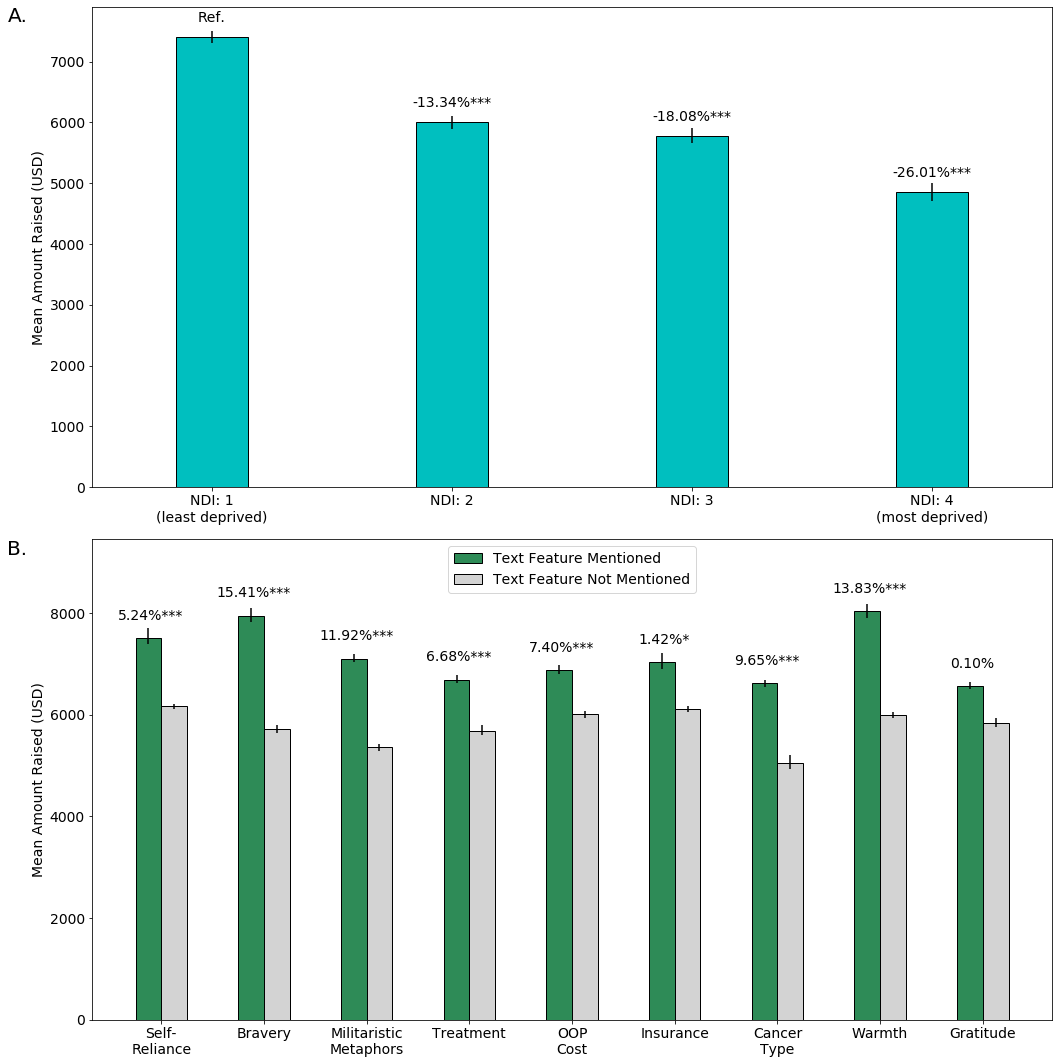

In [109]:
fig, (ax2, ax1) = plt.subplots(nrows = 2, figsize = (15, 15))
#Set top axis
temp_ndi['fmt_var_val'] = ['NDI: 1\n(least deprived)', 'NDI: 2',
                          'NDI: 3', 'NDI: 4\n(most deprived)']
#compute error bars
temp_ndi['lower_errors'] = temp_ndi['mean_amnt_raised'] - temp_ndi['lower_mean_ci']
temp_ndi['upper_errors'] = temp_ndi['upper_mean_ci'] - temp_ndi['mean_amnt_raised']

ax2.bar(temp_ndi['fmt_var_val'], temp_ndi['mean_amnt_raised'],
       yerr = [temp_ndi['lower_errors'], temp_ndi['upper_errors']],
       facecolor='c', ec = 'k', width = 0.3)

ax2.set_ylabel('Mean Amount Raised (USD)')
rects = ax2.patches
rect_labels = ['Ref.']
rect_labels.extend(temp_ndi['labels'].dropna().to_list())
for rect, label in zip(rects, rect_labels):
    width = rect.get_width()
    height = rect.get_height()
    
    y = rect.get_y() + rect.get_height() + 200
    x = rect.get_x() + 0.15
    ax2.text(x, y, label,
            ha='center', va='bottom')
    
ax2.set_ylim(0, max(temp_ndi['mean_amnt_raised'])+500)
ax2.set_xlim(-.5, 3.5)
ax2.text(-0.85, max(temp_ndi['mean_amnt_raised'])+500, 'A.', 
         ha = 'left', va = 'top', size = 20)
set_aspect_ratio(ax2)

#Set the bottom axis
x_vals = np.arange(0, len(merged))

merged['lower_error_bar_g1'] = merged['mean_g1'] - merged['low_mean_ci_g1']
merged['upper_error_bar_g1'] = merged['up_mean_ci_g1'] - merged['mean_g1']
width = 0.25
new_xvals_g1 = [x - width/2 for x in x_vals]
new_xvals_g2 = [x + width/2 for x in x_vals]
ax1.bar(new_xvals_g1, merged['mean_g1'], width, 
                    yerr = [merged['lower_error_bar_g1'], merged['upper_error_bar_g1']],
                    label = 'Text Feature Mentioned',
                    facecolor = 'seagreen',
                    ec = 'k')

rects = ax1.patches
rect_labels = merged['labels'].dropna().to_list()
for rect, label in zip(rects, rect_labels):
    width = rect.get_width()
    height = rect.get_height()
    
    y = rect.get_y() + rect.get_height() + 300
    x = rect.get_x() + 0.15
    ax1.text(x, y, label,
            ha='center', va='bottom')

merged['lower_error_bar_g2'] = merged['mean_g2'] - merged['low_mean_ci_g2']
merged['upper_error_bar_g2'] = merged['up_mean_ci_g2'] - merged['mean_g2']    

ax1.bar(new_xvals_g2, merged['mean_g2'], 
        width, label = 'Text Feature Not Mentioned',
        yerr = [merged['lower_error_bar_g2'], merged['upper_error_bar_g2']],
        facecolor = 'lightgrey',
        edgecolor = 'k')
    
ax1.set_xticks(x_vals)
ax1.set_xticklabels(merged['fmtd_var_name'])

ax1.set_ylim(bottom = 0, top = max(merged['mean_g1'])+1400)
ax1.set_ylabel('Mean Amount Raised (USD)')
ax1.text(-1.5, max(merged['mean_g1'])+1400, 'B.', 
         ha = 'left', va = 'top', size = 20)
set_aspect_ratio(ax1)
ax1.legend(loc = 'upper center')

plt.tight_layout()
plt.savefig(data_io.output_plots/'all_reg_outputs.png', dpi = 400, bbox_inches = 'tight')
plt.show()
